In [7]:
import re

### jelaskan dengan gaya seperti novel yang menarik untuk dibaca dan mudah dimengerti.
### jangan dibuat summary, jelaskan dari awal sampai akhir secara runut.
### jelaskan dalam bahasa indonesia

# teks = '''Prompt: 
# ### Jelaskan dengan bahasa yang mudah dimengerti kepada anak berumur 5 tahun 
# ### Jelaskan istilah tertentu jika ada, jika ada istilah tertentu yang lebih enak di dengar dari bahasa aslinya maka jangan translate ke Indonesia 
# ### Jelaskan secara runut, berdasarkan teks dari awal sampai akhir, jangan ada yang di skip
# '''

# teks = "# teks di atas merupakan terusan dari chat sebelumnya, lakukan hal yang sama seperti chat sebelumnya"

# teks = '### teks tersebut merupakan lanjutan dari teks sebelumnya, saya ingin kamu melakukan hal yang sama seperti teks sebelumnya.'

teks = '''Prompt: 
### Jelaskan dengan bahasa yang mudah dimengerti kepada orang yang baru belajar 
### Jangan gunakan istilah yang sulit
### Jangan ubah istilah asing ke bahasa indonesia, jika itu menyangkut dengan materi yang dibahas 
### Jelaskan secara runut, berdasarkan teks dari awal sampai akhir, jangan ada yang di skip
'''

with open("subtitle.txt", "r+", encoding='utf-8') as f:
  isi = f.read()
  isi_baru = re.sub(teks, ' ', isi).replace('\n', ' ')
  
  f.seek(0)
  f.write(isi_baru + '\n\n' + teks)
  # f.write(isi_baru)
  f.truncate()
  print(len(isi))

2193


In [ ]:
# Prompt: 
### Jelaskan dalam bentuk narasi terlebih dahulu, lalu untuk istilah asing dibuat secara point untuk definisi
### Jelaskan dengan bahasa yang mudah dimengerti kepada anak berumur 6 tahun
### Jelaskan secara runut, berdasarkan teks dari awal sampai akhir, jangan ada yang di skip

$$

\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{bmatrix}
*
\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
$$

$$
=
(1 \times -1) + (2 \times 0) + (3 \times 1) + (4 \times -2) + (5 \times 0) + (6 \times 2) + (7 \times -1) + (8 \times 0) + (9 \times 1)
= -4
$$

Fungsi kerugian SRGAN adalah salah satu inovasi utamanya. Perbedaan penting antara SRGAN dan algoritma super-resolusi lainnya adalah pelestarian detail frekuensi tinggi. SRGAN menyajikan kerugian perceptual untuk mengatasi kurangnya detail. Fungsi kerugian berisi kerugian konten dan kerugian adversarial, dan ditimbang kembali dengan otoritas tertentu. Rumus matematikanya dinyatakan sebagai:

$$l^{SR}=l_X^{SR}+{10}^{-3}l_{Gen}^{SR}$$

di antaranya $l_X^{SR}$ adalah kerugian konten, $l_{Gen}^{SR}$ adalah kerugian adversarial, $l^{SR}$ untuk kerugian total.

Kerugian konten adalah fungsi yang mengukur kesamaan antara gambar super-resolusi dan gambar asli dalam ruang fitur yang diekstraksi oleh jaringan VGG. Kerugian konten didefinisikan sebagai:

$$l_X^{SR}=\frac{1}{W_{i,j}H_{i,j}}\sum_{x=1}^{W_{i,j}}\sum_{y=1}^{H_{i,j}}(F_{i,j}(I^{HR})-F_{i,j}(G(I^{LR})))^2$$

di mana $F_{i,j}$ adalah peta fitur dari lapisan ke-$j$ dari jaringan VGG ke-$i$, $W_{i,j}$ dan $H_{i,j}$ adalah dimensi spasial dari peta fitur, $I^{HR}$ adalah gambar asli resolusi tinggi, $I^{LR}$ adalah gambar resolusi rendah, dan $G$ adalah jaringan generatif.

Kerugian adversarial adalah fungsi yang mengukur kemampuan jaringan generatif untuk menipu jaringan diskriminatif. Kerugian adversarial didefinisikan sebagai:

$$l_{Gen}^{SR}=-\log D(G(I^{LR}))$$

di mana $D$ adalah jaringan diskriminatif yang mengeluarkan probabilitas bahwa gambar masukan berasal dari kumpulan data asli.

In [ ]:
def residual_block(x, filters=64):
    x1 = Conv2D(filters, 3, padding='same')(x)
    x1 = BatchNormalization()(x1)
    x1 = PReLU(shared_axes=[1, 2])(x1)
    x1 = Conv2D(filters, 3, padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x = Add()([x, x1])
    return x
def build_real_esrgan_generator(input_shape=(None, None, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 3, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    for _ in range(23):
        x = residual_block(x, 64)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, inputs])
    x = Conv2D(256, 3, padding='same')(x)
    x = Lambda(lambda x: x * 0.1)(x)  # Scale output to [-1, 1] for tanh activation
    x = Conv2D(3, 3, padding='same', activation='linear')(x)
    generator = Model(inputs, x, name='real_esrgan_generator')
    return generator
def build_real_esrgan_model(generator):
    generator.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
    esrgan_input = Input(shape=(None, None, 3))
    generated_image = generator(esrgan_input)
    real_esrgan_model = Model(esrgan_input, generated_image, name='real_esrgan')
    return real_esrgan_model
def build_real_esrgan_discriminator(input_shape=(None, None, 3)):
    inputs = Input(shape=input_shape)
    x = SpectralNormalization(Conv2D(64, 3, padding='same'))(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = SpectralNormalization(Conv2D(64, 3, strides=2, padding='same'))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.5)(x)
    x = SpectralNormalization(Conv2D(128, 3, padding='same'))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = SpectralNormalization(Conv2D(128, 3, strides=2, padding='same'))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.5)(x)
    x = SpectralNormalization(Conv2D(256, 3, padding='same'))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = SpectralNormalization(Conv2D(256, 3, strides=2, padding='same'))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    discriminator = Model(inputs, x, name='real_esrgan_discriminator')
    return discriminator
inputs = (64, 64, 3)
real_esrgan_generator = build_real_esrgan_generator(inputs)
real_esrgan_generator.summary()
real_esrgan_model = build_real_esrgan_model(real_esrgan_generator)
real_esrgan_model.summary()
real_esrgan_discriminator = build_real_esrgan_discriminator()
real_esrgan_discriminator.summary()

In [ ]:
# Assuming the text above is stored in a variable called text
text = """1.
Question 1
How do you add a 1 dimensional convolution to your model for predicting time series data?




1 / 1 point

Use a Conv1D layer type



Use a ConvolutionD1 layer type



Use a 1DConvolution layer type



Use a 1DConv layer type"""

# Strip any leading or trailing whitespace from the text
text = text.strip()

# Split the text into lines and remove empty lines
lines = [line for line in text.split("\n") if line]

# Extract the question number, question text and point value
question_number = lines[0].strip(".")
question_text = lines[1].strip("Question ")
point_value = lines[2].strip(" / 1 point")

# Extract the answer choices and assign them letters
answer_choices = lines[3:]
letters = ["A", "B", "C", "D"]
answer_dict = dict(zip(letters, answer_choices))

# Format the output text using f-strings
output = f"{question_number}. {question_text}\n"
for letter, answer in answer_dict.items():
    output += f"{letter}. {answer}\n"

# Print the output text
print(output)

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Define the input shape
input_shape = (64, 64, 3) # For example, blurred images
hr_input_shape = (256, 256, 3) # For example, sharp images

# Define the encoder model
input_layer = keras.layers.Input(shape=input_shape)
x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.Flatten()(x)
latent_space = keras.layers

In [ ]:
def build_encoder(input_shape):
    inputs = Input(shape=input_shape)
    # Definisi Encoder
    # ...
    return Model(inputs=inputs, outputs=...)
def build_decoder(input_shape):
    inputs = Input(shape=input_shape)
    # Definisi Decoder
    # ...
    return Model(inputs=inputs, outputs=...)
def build_autoencoder(input_shape):
    encoder = build_encoder(input_shape)
    decoder = build_decoder(encoder.output_shape[1:])
    autoencoder_outputs = decoder(encoder.outputs)
    return Model(inputs=encoder.inputs, outputs=autoencoder_outputs)
def pixel_shuffle(scale):
    return Lambda(lambda x: tf.nn.depth_to_space(x, scale, data_format='NHWC'))
def build_generator(scale=2):
    input_shape = (None, None, 3)
    autoencoder = build_autoencoder(input_shape)
    x = Conv2D(64 * scale ** 2, kernel_size=3, strides=1, padding='same', name='conv_upscale')(autoencoder.output)  # Menambahkan scale ** 2 kali channel
    x = pixel_shuffle(scale)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(3, kernel_size=9, strides=1, padding='same', activation='relu', name='conv_output')(x)  # Menggunakan relu sebagai fungsi aktivasi
    outputs = (x + 1.0) * 0.5
    return Model(inputs=autoencoder.input, outputs=outputs)
def build_discriminator():
    input_shape = (None, None, 3)
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, kernel_size=3, strides=2, padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1, kernel_size=3, strides=1, padding='same')(x)
    x = Activation('sigmoid')(x)  
    outputs = tf.keras.layers.Flatten()(x)
    return Model(inputs=inputs, outputs=outputs)
vgg = VGG19(include_top=False, input_shape=(None, None, 3))
vgg.trainable = False
vgg_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
def vgg_loss(y_true, y_pred):
    return MeanAbsoluteError()(vgg_model(y_true), vgg_model(y_pred))
generator = build_generator()
discriminator = build_discriminator()
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
def generator_loss(fake_output):
    return BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)
def discriminator_loss(real_output, fake_output):
    real_loss = BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss
def psnr_metric(y_true, y_pred):
    return psnr(y_true, y_pred, max_val=1.0)
def ssim_metric(y_true, y_pred):
    return ssim(y_true, y_pred, max_val=1.0)
@tf.function
def train_step(lr_images, hr_images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(lr_images, training=True)
        real_output = discriminator(hr_images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss.numpy(), disc_loss.numpy()

# ====== same code ====================

In [63]:
import pandas as pd

df = pd.read_csv('./training_final.log', sep='\t')
target_index = df.loc[df.isnull().any(axis=1)].index
interpolated_df = df.interpolate()

df.loc[target_index]

,epoch,loss,lr,psnr,val_loss,val_psnr


In [2]:
target_index

Index([], dtype='int64', name='epoch')

In [11]:
interpolated_df.loc[[790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800]]

,loss,lr,psnr,val_loss,val_psnr
epoch,,,,,
790,0.004609,0.00025,25.598587,0.006700,23.804373
791,0.004614,0.00025,25.593535,0.006696,23.807384
792,0.004619,0.00025,25.588482,0.006692,23.810395
793,0.004624,0.00025,25.583430,0.006688,23.813406
794,0.004629,0.00025,25.578377,0.006683,23.816417
795,0.004633,0.00025,25.573325,0.006679,23.819427
796,0.004638,0.00025,25.568273,0.006675,23.822438
797,0.004643,0.00025,25.563220,0.006671,23.825449
798,0.004648,0.00025,25.558168,0.006667,23.828460


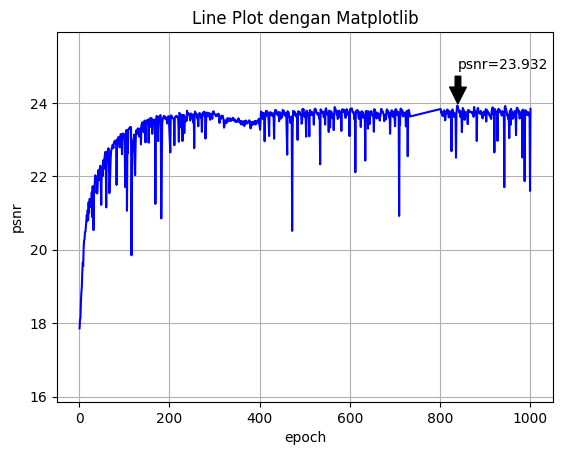

In [40]:
import matplotlib.pyplot as plt

val_psnr_max = df['val_psnr'].max()
max_index_val_psnr = df[df['val_psnr'] == val_psnr_max].index[0]

plt.plot(df.index, df['val_psnr'], color='blue', label='val_psnr')

plt.title('Line Plot dengan Matplotlib')

plt.xlabel('epoch')
plt.ylabel('psnr')

plt.annotate(f'psnr={round(val_psnr_max, 3)}', # Teks annote
             xy=(df.index[max_index_val_psnr], df['val_psnr'][max_index_val_psnr]), # Titik yang diannote
             xytext=(df.index[max_index_val_psnr]+0.5, df['val_psnr'][max_index_val_psnr]+1), # Posisi teks
             arrowprops=dict(facecolor='black', shrink=0.05), # Gaya panah
             )

plt.ylim(df['val_psnr'].min() - 2, df['val_psnr'].max() + 2)
plt.grid()
plt.show()

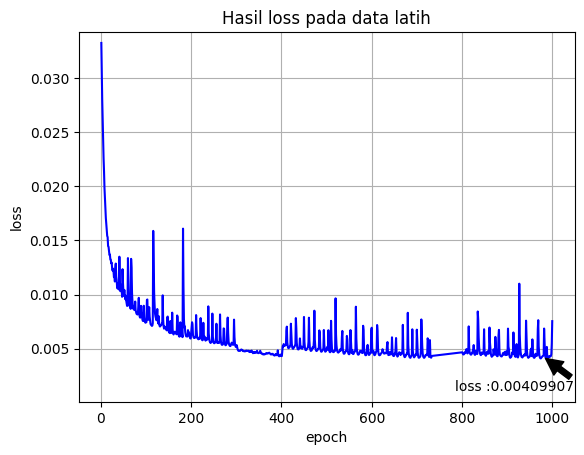

In [137]:
# Buat fungsi untuk membuat line plot dari dataframe
def line_plot(df, y_column, x_column, agg, color, title, x_text_offset:int, y_text_offset:int, offset_y_lower:int, offset_y_upper:int):
    # Buat objek plot
    plot = plt.figure()
    # Buat line plot dari kolom yang dipilih
    plt.plot(df[y_column], df[x_column], color=color, label=x_column, linestyle='-')
    # Tambahkan judul untuk plot
    plt.title(title)
    # Tambahkan label untuk sumbu x dan y
    plt.xlabel(y_column)
    plt.ylabel(x_column)
    # Tambahkan annote untuk nilai maksimum dengan teks dan panah

    annote_val = df[x_column].agg(agg)
    target_index_annote_val = df[df[x_column] == annote_val].index[0]

    plt.annotate(f"{str(x_column)} :{annote_val:.6}", # Teks annote
                 xy=(target_index_annote_val, annote_val), # Titik yang diannote
                 xytext=(target_index_annote_val-x_text_offset, annote_val+y_text_offset), # Posisi teks
                 arrowprops=dict(facecolor='black', shrink=0.001), # Gaya panah
                 )
    # Tambahkan warna pada area plot
    plt.ylim(df[x_column].min() - offset_y_lower, df[x_column].max() + offset_y_upper)
    # Tambahkan grid pada plot
    plt.grid()
    # Kembalikan objek plot
    plt.show()

line_plot(df, 'epoch', 'loss', 'min', 'blue', 'Hasil loss pada data latih', 200, -0.003, 0.004, 0.001)

In [1]:
import re

# Fungsi untuk mengekstrak nilai dari log
def extract_values(log_line):
    match = re.search(r'epoch: (\d+) g_loss: ([\d.]+) g_psnr: ([\d.-]+) d_loss: \[([\d.e-]+) ([\d.e-]+)\] learning_rate_srgan: ([\d.e-]+)', log_line)
    if match:
        epoch = int(match.group(1))
        g_loss = float(match.group(2))
        g_psnr = float(match.group(3))
        d_loss = [float(match.group(4)), float(match.group(5))]
        learning_rate_srgan = float(match.group(6))
        return epoch, g_loss, g_psnr, d_loss, learning_rate_srgan
    return None

# Fungsi untuk mengonversi log ke format yang diinginkan
def convert_log(input_log):
    lines = input_log.split('\n')
    converted_logs = []

    # Header
    converted_logs.append('epoch,g_loss,g_psnr,d_loss,learning_rate_srgan')

    # Proses setiap baris log
    for line in lines:
        values = extract_values(line)
        if values:
            epoch, g_loss, g_psnr, d_loss, learning_rate_srgan = values
            converted_logs.append(f"{epoch},{g_loss},{g_psnr},{d_loss},{learning_rate_srgan}")

    return '\n'.join(converted_logs)

# Log asli
original_log = """
100%|██████████| 7200/7200 [22:09<00:00,  5.42it/s]
epoch: 1 g_loss: 20.911580878628627 g_psnr: -2.6839680671691895 d_loss: [0.01051006 0.99747586] learning_rate_srgan: 1e-04

Model Saved!!
100%|██████████| 7200/7200 [21:51<00:00,  5.49it/s]
epoch: 2 g_loss: 12.154135894692606 g_psnr: -2.833202838897705 d_loss: [0.00232346 0.99959907] learning_rate_srgan: 1e-04

Model Saved!!
100%|██████████| 7200/7200 [21:51<00:00,  5.49it/s]
epoch: 3 g_loss: 10.550306290595067 g_psnr: -1.095978856086731 d_loss: [1.24535838e-05 9.99997830e-01] learning_rate_srgan: 1e-04

Model Saved!!
100%|██████████| 7200/7200 [21:44<00:00,  5.52it/s]
epoch: 4 g_loss: 9.567915422734288 g_psnr: -0.30543601512908936 d_loss: [1.33654935e-08 1.00000000e+00] learning_rate_srgan: 1e-04

Model Saved!!
100%|██████████| 7200/7200 [21:49<00:00,  5.50it/s]
epoch: 5 g_loss: 8.897327683493495 g_psnr: 0.26711052656173706 d_loss: [4.54249462e-09 1.00000000e+00] learning_rate_srgan: 1e-04
"""

# Konversi log
converted_log = convert_log(original_log)

# Print log yang telah diubah
print(converted_log)


epoch,g_loss,g_psnr,d_loss,learning_rate_srgan
1,20.911580878628627,-2.6839680671691895,[0.01051006, 0.99747586],0.0001
2,12.154135894692606,-2.833202838897705,[0.00232346, 0.99959907],0.0001
3,10.550306290595067,-1.095978856086731,[1.24535838e-05, 0.99999783],0.0001


In [8]:
import re

# Fungsi untuk mengekstrak nilai dari log
def extract_values(log_line):
    match = re.search(r'epoch: (\d+) g_loss: ([\d.]+) g_psnr: ([\d.-]+) d_loss: \[([\d.e-]+) ([\d.e-]+)\] learning_rate_srgan: ([\d.e-]+)', log_line)
    if match:
        epoch = int(match.group(1))
        g_loss = float(match.group(2))
        g_psnr = float(match.group(3))
        d_loss = [float(match.group(4)), float(match.group(5))]
        learning_rate_srgan = float(match.group(6))
        return epoch, g_loss, g_psnr, d_loss, learning_rate_srgan
    return None

# Fungsi untuk mengonversi log ke format yang diinginkan
def convert_log(input_file):
    converted_logs = []

    # Header
    converted_logs.append('epoch,g_loss,g_psnr,d_loss,learning_rate_srgan')

    with open(input_file, 'r') as file:
        lines = file.readlines()

        # Proses setiap baris log
        for line in lines:
            values = extract_values(line)
            if values:
                epoch, g_loss, g_psnr, d_loss, learning_rate_srgan = values
                converted_logs.append(f"{epoch},{g_loss},{g_psnr},{d_loss},{learning_rate_srgan}")

    return '\n'.join(converted_logs)

# Nama file log
file_path = './my_text.txt'

# Konversi log
converted_log = convert_log(file_path)

# Print log yang telah diubah
print(converted_log)


epoch,g_loss,g_psnr,d_loss,learning_rate_srgan
1,20.911580878628627,-2.6839680671691895,[0.01051006, 0.99747586],0.0001
2,12.154135894692606,-2.833202838897705,[0.00232346, 0.99959907],0.0001
3,10.550306290595067,-1.095978856086731,[1.24535838e-05, 0.99999783],0.0001
15,6.303560275166399,2.6888580322265625,[0.000949691767, 0.999785156],0.0001
16,6.181252031893366,2.8075387477874756,[5.2382606e-06, 0.999999186],0.0001
18,5.968321195604901,2.787630319595337,[0.000357378484, 0.999902615],0.0001
20,5.781535094082355,2.9603161811828613,[0.000587159151, 0.999867622],0.0001
21,5.702006088619431,3.1727676391601562,[0.000825529982, 0.999883355],0.0001
23,5.543299564760592,3.2643771171569824,[6.01882531e-06, 0.999998644],0.0001
24,5.475147765767243,3.147235870361328,[0.000134295234, 0.999955783],0.0001
27,5.292186283705135,3.4220454692840576,[0.000674968136, 0.999906955],0.0001
28,5.239497246700856,3.320094347000122,[9.66836967e-07, 0.999999729],0.0001
